# Combine data

In [3]:
import pandas as pd
import os, os.path
import numpy as np
from itertools import product
from shapely.geometry import LinearRing, Polygon, Point, LineString, box
import geopandas as gpd
import matplotlib.pyplot as plt
import math
from math import radians, sin, cos, asin, sqrt, atan2
from time import time
from scipy.interpolate import RegularGridInterpolator

%matplotlib inline

In [4]:
dir_name = "../data"
pickles = '../data/pickles/'
gcs_bucket = "https://storage.googleapis.com/w210data/"


if not os.path.isdir(dir_name):
    os.mkdir(dir_name)
    
def download_file(file_name):
    full_path = os.path.join(dir_name, file_name)
    if not os.path.exists(full_path):
        urllib.urlretrieve (gcs_bucket+file_name, full_path)

download_file(pickles+'bathymetry.pkl')

# Read Pickle Files

In [145]:
os.listdir(pickles)

['aerial_kelp_hundreththkm.pkl',
 'aerial_kelp_tenthkm.pkl',
 'bathymetry.pkl',
 'boatlaunches.pkl',
 'ca_counties.pkl',
 'crit_species.pkl',
 'grid_df.pkl',
 'halibuttrawl.pkl',
 'kelp_biomass.pkl',
 'marinas.pkl',
 'min_light.pkl',
 'mixedl.pkl',
 'mpa.pkl',
 'nes_occupation.pkl',
 'oilplats.pkl',
 'piers.pkl',
 'qcew_occupation.pkl',
 'shoretypes.pkl',
 'sst_ca.pkl',
 'temp_floor.pkl',
 'unemployment.pkl']

In [146]:
#we will need to convert some geometries from lat, lon to lon,lat
def flip_coords(geom):
    if type(geom) == Polygon:
        coords = geom.exterior.coords.xy 
        geomtype = 'Polygon'
    elif type(geom) == LineString:
        coords = geom.coords.xy
        geomtype = 'LineString'
    elif type(geom) == Point:
        coords = geom.coords.xy
        geomtype = 'Point'
    else:
        print("not a known geom type")
        return 
    flipped_coords = list(zip(coords[1],coords[0]))
    if geomtype == 'Polygon':
        return Polygon(flipped_coords) 
    elif geomtype == 'LineString':
        return LineString(flipped_coords)
    elif geomtype == 'Point':
        return Point(flipped_coords)

In [147]:
#Pickle files come from data/read_data.ipynb and
#bathymetry is not a gpd df
bathymetry = pd.read_pickle(pickles+'bathymetry.pkl')
print(bathymetry.shape)
bathymetry.head()

(5371, 4)


,x,y,z,geometry
1614,-124.45,40.400000,-50.0,POINT (-124.45 40.40000000000003)
1615,-124.45,40.416667,-38.0,POINT (-124.45 40.41666666666669)
1616,-124.45,40.433333,-32.0,POINT (-124.45 40.43333333333336)
1617,-124.45,40.450000,-29.0,POINT (-124.45 40.45000000000002)
1618,-124.45,40.466667,-31.0,POINT (-124.45 40.46666666666669)


In [148]:
#in lon, lat format
counties = pd.read_pickle(pickles+'ca_counties.pkl')
counties.head()

,STATEFP,COUNTYFP,NAME,geometry
0,6,75,San Francisco,"POLYGON ((-122.511983 37.77113, -122.465396 37..."
705,6,87,Santa Cruz,"POLYGON ((-122.317682 37.186945, -122.152774 3..."
713,6,31,Kings,"POLYGON ((-120.315068 35.907186, -119.959058 3..."
899,6,85,Santa Clara,"POLYGON ((-122.190402 37.431472, -122.144933 3..."
915,6,21,Glenn,"POLYGON ((-122.911794 39.799485, -122.046471 3..."


In [149]:
#in lon lat format except for leatherbacks which is all messed up
crit_species = pd.read_pickle(pickles+'crit_species.pkl')
crit_species.head()

,species,geometry
0,black abalone,"POLYGON ((-123.5053264870277 38.7405412355896,..."
1,black abalone,POLYGON ((-123.0726524775298 38.31072869617242...
2,black abalone,POLYGON ((-122.5006060204515 37.50355915762907...
3,black abalone,POLYGON ((-122.5097393606829 37.50326748590578...
4,black abalone,POLYGON ((-122.4114904047584 37.26741997175435...


In [150]:
#in lat lon format
protected_areas = pd.read_pickle(pickles+'mpa.pkl')
protected_areas.Geometry = protected_areas.Geometry.apply(flip_coords)
protected_areas = gpd.GeoDataFrame(protected_areas, crs = {'init' :'epsg:4326'}, geometry='Geometry')

In [151]:
#does not have geom. just county names (and fips state and county codes)
occupation_nes = pd.read_pickle(pickles+'nes_occupation.pkl')
occupation_nes.head()

,estab,estab_f,naics,year,State,fips_state,fips_county,name,STATE,COUNTY,STNAME,CTYNAME,population,pct
0,42,NaN,11411,2010,CA,6,1,Alameda County,6,1,California,Alameda County,1513402,0.000028
1,71,NaN,11411,2011,CA,6,1,Alameda County,6,1,California,Alameda County,1532215,0.000046
2,63,NaN,11411,2012,CA,6,1,Alameda County,6,1,California,Alameda County,1556648,0.000040
3,65,NaN,11411,2013,CA,6,1,Alameda County,6,1,California,Alameda County,1582936,0.000041
4,64,NaN,11411,2014,CA,6,1,Alameda County,6,1,California,Alameda County,1611572,0.000040


In [152]:
#does not have geom. just county names (and fips state and county codes)
occupation_qcew = pd.read_pickle(pickles+'qcew_occupation.pkl')
occupation_qcew.head()

,area_fips,industry_code,agglvl_code,size_code,year,disclosure_code,annual_avg_estabs,annual_avg_emplvl,fips_county,fips_state,State,name,fips_class_code,STATE,COUNTY,STNAME,CTYNAME,population,estab_pct,emp_pct
0,06007,11251,77,0,2013,N,1,0,7,6,CA,Butte County,H1,6,7,California,Butte County,221768,0.000005,0.000000
1,06015,11251,77,0,2013,N,1,0,15,6,CA,Del Norte County,H1,6,15,California,Del Norte County,27830,0.000036,0.000000
2,06015,11411,77,0,2013,NaN,39,81,15,6,CA,Del Norte County,H1,6,15,California,Del Norte County,27830,0.001401,0.002911
3,06019,11251,77,0,2013,N,4,0,19,6,CA,Fresno County,H1,6,19,California,Fresno County,953787,0.000004,0.000000
4,06023,11251,77,0,2013,NaN,6,19,23,6,CA,Humboldt County,H1,6,23,California,Humboldt County,134444,0.000045,0.000141


In [153]:
unemployment = pd.read_pickle(pickles+'unemployment.pkl')

In [154]:
#in lat lon format
kelp_biomass =pd.read_pickle(pickles+'kelp_biomass.pkl')
kelp_biomass.geometry = kelp_biomass.geometry.apply(flip_coords)
kelp_biomass.head()
#kelp_biomass.geometry.apply(type).unique() all points

,lat,lon,biomass,geometry
0,32.519277,-117.142836,265.0,POINT (-117.1428356 32.51927713)
1,32.519547,-117.143155,635.0,POINT (-117.1431554 32.5195474)
2,32.519548,-117.142836,275.0,POINT (-117.142836 32.51954776)
3,32.519548,-117.142197,272.0,POINT (-117.1421972 32.51954849)
4,32.519818,-117.143156,565.0,POINT (-117.1431559 32.51981803)


In [155]:
#will be converted to lon lat format
sst = pd.read_pickle(pickles+'sst_ca.pkl')
sst.geometry = sst.geometry.apply(flip_coords)
sst.head()

,mean_temp,max_temp,min_temp,geometry
0,16.686864,19.299982,14.749994,POINT (-124 32.5)
1,16.615615,19.239984,14.249994,POINT (-123.75 32.5)
2,16.574993,19.200006,13.829980,POINT (-123.5 32.5)
3,16.543119,19.159998,13.589990,POINT (-123.25 32.5)
4,16.536871,19.129999,13.359979,POINT (-123 32.5)


# read minimum light depth

In [156]:
z_min_light = pd.read_pickle(pickles+'min_light.pkl')
z_min_light.head()
#plt.hist(z_min_light.z_min_light)

,geometry,z_min_light
index_left,,
0,POINT (-124.4791717529297 42.1875),35
1,POINT (-124.4375076293945 42.1875),35
2,POINT (-124.3958358764648 42.1875),0
3,POINT (-124.3541717529297 42.1875),0
4,POINT (-124.3125076293945 42.1875),0


# read mixed layer

In [157]:
mixedl = pd.read_pickle(pickles+'mixedl.pkl')
mixedl.head()
#plt.hist(mixedl.mean_mld)

,geometry,mean_mld
iNPROF,,
2325,POINT (-123.031997680664 36.3499984741211),17.643838
2326,POINT (-122.782997131348 36.2389984130859),19.306555
2327,POINT (-122.656997680664 36.0320014953613),17.594704
2328,POINT (-122.785003662109 35.9490013122559),31.267630
2329,POINT (-122.830001831055 35.9910011291504),30.126088


# read ocean floor temps

In [158]:
floor_temps = pd.read_pickle(pickles+'temp_floor.pkl')

# Create grid of California

In [159]:
def squarify(point, increment):
    return Polygon([(point[0], point[1]),
     (point[0] + increment, point[1]), 
     (point[0] + increment, point[1] + increment), 
     (point[0], point[1] + increment)])

def desquarify(left_vertices, right_vertices, square_length):
    x_num = round((right_vertices[0] - left_vertices[0])/square_length, 0)
    y_num = round((right_vertices[1] - left_vertices[1])/square_length, 0)
    x_lengths = np.linspace(left_vertices[0], right_vertices[0]-square_length, x_num)
    y_lengths = np.linspace(left_vertices[1], right_vertices[1]-square_length, y_num)
    return [p for p in product(x_lengths, y_lengths)]

In [12]:
def haversine(p1,p2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees).
    Source: https://gis.stackexchange.com/a/56589/15183
    """
    lon1 = p1[0]
    lat1 = p1[1]
    lon2 = p2[0]
    lat2 = p2[1]
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    km = 6373 * c
    return km

In [11]:
#just get the base distance for one point b/c this will be close to the the right scaling
#add half a degee in lat and lon to get the second point
def get_distance_ratio(shape):
    p1 = list(shape.representative_point().coords)[0]
    p2 = (p1[0]+0.5,p1[1]+0.5)
    d_km = haversine(p1,p2)
    #just get the base distance for one point b/c this will be close to the the right scaling for all p2s
    base_coord_d=Point(p1).distance(Point(p2))
    return d_km/base_coord_d
def get_distance_to_object(shape, areas):
    distance_ratio = get_distance_ratio(shape)
    distance = np.min([shape.distance(i) for i in land.geometry])*distance_ratio
    return distance

In [162]:
#create vertices for California
#roughly the bounds of california going out 8km past cape mendocino
width = .01
#(32.534343,-124.511849),(42.00,-117.123885)
grid_bottomleft_vertices = desquarify((-124.511849,32.534343),(-117.123885,42), width)
grid = [squarify(i, width) for i in grid_bottomleft_vertices]
grid_df = gpd.GeoDataFrame(geometry=grid, crs = {'init' : 'epsg:4326'})
grid_df["polygon_id"] = range(len(grid))

# Cull data to just areas near coast and not on land
#import state shapefiles
states = gpd.read_file('../data/state_shapefiles/cb_2017_us_state_20m.shp')
land = states[states['STATEFP'] == '06']
# change the CRS
land = land.set_geometry('geometry').to_crs({'init':'epsg:4326'})

# cull polygons on land
print("before culling land there are {} rows".format(grid_df.shape[0]))
grid_df = gpd.sjoin(grid_df, land, op='within', how='left')
print(grid_df.head())
grid_df.fillna(-99999, inplace=True)
grid_df = grid_df[grid_df['index_right'] <0]
print("after culling land there are {} rows".format(grid_df.shape[0]))
grid_df = grid_df.iloc[:,:2]

#cull polygons far from shore
#EEZ extends 3 nautical miles (5.556 km) from coast. 
eez = 5.556
print("before culling far away sites there are {} rows".format(grid_df.shape[0]))
grid_df['land_distance'] = grid_df.geometry.apply(lambda x: get_distance_to_object(x,land.geometry))
grid_df = grid_df[grid_df['land_distance'] <eez]
print("after culling far away sites there are {} rows".format(grid_df.shape[0]))
print(grid_df.shape)
print(len(grid_df.polygon_id.unique()))
grid_df.head()

/home/clay/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  # Remove the CWD from sys.path while we load stuff.
/home/clay/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  # This is added back by InteractiveShellApp.init_path()


before culling land there are 699833 rows
                                            geometry  polygon_id  index_right  \
0  POLYGON ((-124.511849 32.534343, -124.501849 3...           0          NaN   
1  POLYGON ((-124.511849 32.54433840909091, -124....           1          NaN   
2  POLYGON ((-124.511849 32.55433381818182, -124....           2          NaN   
3  POLYGON ((-124.511849 32.56432922727273, -124....           3          NaN   
4  POLYGON ((-124.511849 32.57432463636363, -124....           4          NaN   

  STATEFP STATENS AFFGEOID GEOID STUSPS NAME LSAD  ALAND  AWATER  
0     NaN     NaN      NaN   NaN    NaN  NaN  NaN    NaN     NaN  
1     NaN     NaN      NaN   NaN    NaN  NaN  NaN    NaN     NaN  
2     NaN     NaN      NaN   NaN    NaN  NaN  NaN    NaN     NaN  
3     NaN     NaN      NaN   NaN    NaN  NaN  NaN    NaN     NaN  
4     NaN     NaN      NaN   NaN    NaN  NaN  NaN    NaN     NaN  
after culling land there are 370668 rows
before culling far away site

,geometry,polygon_id,land_distance
4576,POLYGON ((-124.4718600352303 40.41072536363637...,4576,5.436725
4577,POLYGON ((-124.4718600352303 40.42072077272727...,4577,5.210421
4578,POLYGON ((-124.4718600352303 40.43071618181818...,4578,5.159305
4579,POLYGON ((-124.4718600352303 40.44071159090909...,4579,5.165576
4580,"POLYGON ((-124.4718600352303 40.450707, -124.4...",4580,5.307229


# Combine Data

In [10]:
def get_closest_areas(shape,areas, area_names,max_distance, min_returned=3, max_returned=None):
    distance_ratio = get_distance_ratio(shape)
    distances = [shape.distance(i)*distance_ratio for i in areas]
    sorted_distances = np.sort(distances)
    areas_within_max = sorted_distances < max_distance
    num_close_areas = sum(areas_within_max)
    if num_close_areas < min_returned:
        lowest_distances = sorted_distances[:min_returned]
        area_idx = np.argsort(distances)[:min_returned]
    else:
        lowest_distances = sorted_distances[:num_close_areas]
        area_idx = np.argsort(distances)[:num_close_areas]
    
    if max_returned:
        area_idx = area_idx[:max_returned]
        lowest_distances = lowest_distances[:max_returned]
        
    names = area_names.iloc[area_idx]
    return list(zip(area_idx, names, lowest_distances))

In [164]:
#distance in km does seem to vary for the same difference in latitude/long depending on your latitude.
print(haversine((-122,32.5),(-121,32.5)))
print(haversine((-122,32.5),(-122,33.5)))
print(haversine((-122,42),(-121,42)))
print(haversine((-122,42),(-122,41)))
print(haversine((-122,41),(-122.0166667,41)))

93.80994612038263
111.22983322959878
82.65940525349976
111.22983322959878
1.3991064751674347


In [165]:
grid_df['pretected_areas'] = grid_df.geometry.apply(lambda x: get_closest_areas(x,protected_areas.Geometry,\
                                                                                protected_areas.Name,\
                                                                                10))
grid_df['county'] = grid_df.geometry.apply(lambda x: get_closest_areas(x,counties.geometry,\
                                                                                counties.NAME,\
                                                                                10,1))
grid_df.head()

,geometry,polygon_id,land_distance,pretected_areas,county
4576,POLYGON ((-124.4718600352303 40.41072536363637...,4576,5.436725,"[(10, South Cape Mendocino State Marine Reserv...","[(21, Humboldt, 5.436724953944683)]"
4577,POLYGON ((-124.4718600352303 40.42072077272727...,4577,5.210421,"[(10, South Cape Mendocino State Marine Reserv...","[(21, Humboldt, 5.21042108067394)]"
4578,POLYGON ((-124.4718600352303 40.43071618181818...,4578,5.159305,"[(10, South Cape Mendocino State Marine Reserv...","[(21, Humboldt, 5.159304624869962)]"
4579,POLYGON ((-124.4718600352303 40.44071159090909...,4579,5.165576,"[(10, South Cape Mendocino State Marine Reserv...","[(21, Humboldt, 5.1655764432122115)]"
4580,"POLYGON ((-124.4718600352303 40.450707, -124.4...",4580,5.307229,"[(10, South Cape Mendocino State Marine Reserv...","[(21, Humboldt, 5.30722856721387)]"


In [166]:
grid_df['critical_species'] = grid_df.geometry.apply(lambda x: get_closest_areas(x,crit_species.geometry,\
                                                                                crit_species.species,\
                                                                                10))
grid_df.head()

,geometry,polygon_id,land_distance,pretected_areas,county,critical_species
4576,POLYGON ((-124.4718600352303 40.41072536363637...,4576,5.436725,"[(10, South Cape Mendocino State Marine Reserv...","[(21, Humboldt, 5.436724953944683)]","[(41, green sturgeon, 0.0), (22, stellar sea l..."
4577,POLYGON ((-124.4718600352303 40.42072077272727...,4577,5.210421,"[(10, South Cape Mendocino State Marine Reserv...","[(21, Humboldt, 5.21042108067394)]","[(41, green sturgeon, 0.0), (22, stellar sea l..."
4578,POLYGON ((-124.4718600352303 40.43071618181818...,4578,5.159305,"[(10, South Cape Mendocino State Marine Reserv...","[(21, Humboldt, 5.159304624869962)]","[(41, green sturgeon, 0.0), (22, stellar sea l..."
4579,POLYGON ((-124.4718600352303 40.44071159090909...,4579,5.165576,"[(10, South Cape Mendocino State Marine Reserv...","[(21, Humboldt, 5.1655764432122115)]","[(41, green sturgeon, 0.0), (22, stellar sea l..."
4580,"POLYGON ((-124.4718600352303 40.450707, -124.4...",4580,5.307229,"[(10, South Cape Mendocino State Marine Reserv...","[(21, Humboldt, 5.30722856721387)]","[(41, green sturgeon, 0.0), (22, stellar sea l..."


In [167]:
grid_df.iloc[0].pretected_areas[0][2]

0.0

## merge occupation data

In [168]:
#get mean levels for establishments and employment and aggregate by year
occupation_avg_qcew = occupation_qcew.groupby(['fips_county','fips_state','industry_code']).mean().reset_index()
occupation_avg_qcew.drop(occupation_avg_qcew.columns[7:10], axis=1, inplace=True)
occupation_avg_qcew.drop(['agglvl_code','size_code'], axis = 1, inplace=True)
occupation_avg_qcew = occupation_avg_qcew.rename(columns={'estab_pct':'qcew_estab_pct','emp_pct':'qcew_emp_pct',\
                                                         'industry_code':'naics'})
occupation_avg_qcew.head()

,fips_county,fips_state,naics,annual_avg_estabs,annual_avg_emplvl,qcew_estab_pct,qcew_emp_pct
0,1,6,11251,0.00,0.0,0.000000e+00,0.0
1,1,6,11411,2.80,0.0,1.721269e-06,0.0
2,7,6,11251,0.50,0.0,2.254608e-06,0.0
3,7,6,11411,1.25,0.0,5.541791e-06,0.0
4,13,6,11251,1.00,0.0,8.844836e-07,0.0


In [169]:
occupation_avg_nes = occupation_nes.groupby(['fips_county','fips_state','naics']).mean().reset_index()
occupation_avg_nes.drop(['STATE','COUNTY','population'], axis=1, inplace=True)
occupation_avg_nes = occupation_avg_nes.rename(columns={'pct':'nes_estab_pct'})
occupation_avg_nes.naics = occupation_avg_nes.naics.astype(int)
occupation_avg_nes.head()

,fips_county,fips_state,naics,estab,nes_estab_pct
0,1,6,11411,58.666667,0.000037
1,5,6,11411,0.000000,0.000000
2,7,6,11411,31.666667,0.000143
3,9,6,11411,10.500000,0.000234
4,11,6,11411,2.833333,0.000133


In [170]:
#combine new and qcew data
all_occupation = occupation_avg_nes.merge(occupation_avg_qcew, on=['fips_county','fips_state','naics'], how='outer')\
                                   .merge(unemployment, on=['fips_county','fips_state'], how='outer')
all_occupation.head()
#all_occupation[all_occupation['fips_county'] == 75].head()

,fips_county,fips_state,naics,estab,nes_estab_pct,annual_avg_estabs,annual_avg_emplvl,qcew_estab_pct,qcew_emp_pct,unemployment_rate
0,1,6,11411.0,58.666667,0.000037,2.80,0.0,0.000002,0.0,3.307143
1,1,6,11251.0,NaN,NaN,0.00,0.0,0.000000,0.0,3.307143
2,5,6,11411.0,0.000000,0.000000,NaN,NaN,NaN,NaN,4.428571
3,7,6,11411.0,31.666667,0.000143,1.25,0.0,0.000006,0.0,5.264286
4,7,6,11251.0,NaN,NaN,0.50,0.0,0.000002,0.0,5.264286


In [171]:
counties.head()

,STATEFP,COUNTYFP,NAME,geometry
0,6,75,San Francisco,"POLYGON ((-122.511983 37.77113, -122.465396 37..."
705,6,87,Santa Cruz,"POLYGON ((-122.317682 37.186945, -122.152774 3..."
713,6,31,Kings,"POLYGON ((-120.315068 35.907186, -119.959058 3..."
899,6,85,Santa Clara,"POLYGON ((-122.190402 37.431472, -122.144933 3..."
915,6,21,Glenn,"POLYGON ((-122.911794 39.799485, -122.046471 3..."


In [172]:
counties = counties.merge(all_occupation, left_on=['STATEFP','COUNTYFP'], right_on=['fips_state','fips_county'], how='outer')
counties.drop(['fips_county','fips_state'], axis=1, inplace=True)
#exclude 11251 naics codes
counties = counties[counties.naics == 11411]
counties.head()

,STATEFP,COUNTYFP,NAME,geometry,naics,estab,nes_estab_pct,annual_avg_estabs,annual_avg_emplvl,qcew_estab_pct,qcew_emp_pct,unemployment_rate
0,6,75,San Francisco,"POLYGON ((-122.511983 37.77113, -122.465396 37...",11411.0,40.333333,0.000048,1.0,0.0,1.157428e-06,0.000000,2.642857
2,6,87,Santa Cruz,"POLYGON ((-122.317682 37.186945, -122.152774 3...",11411.0,76.166667,0.000284,4.8,5.0,1.752913e-05,0.000018,5.257143
4,6,31,Kings,"POLYGON ((-120.315068 35.907186, -119.959058 3...",11411.0,0.666667,0.000004,NaN,NaN,NaN,NaN,8.250000
5,6,85,Santa Clara,"POLYGON ((-122.190402 37.431472, -122.144933 3...",11411.0,62.166667,0.000034,1.0,0.0,5.233124e-07,0.000000,2.914286
6,6,21,Glenn,"POLYGON ((-122.911794 39.799485, -122.046471 3...",11411.0,5.500000,0.000197,NaN,NaN,NaN,NaN,6.921429


In [173]:
counties.shape

(57, 12)

In [174]:
grid_df['nes_estab_pct'] = grid_df.geometry.apply(lambda x: get_closest_areas(x,counties.geometry,\
                                                                                counties.nes_estab_pct,\
                                                                                10,1,1))
grid_df['annual_avg_emplvl'] = grid_df.geometry.apply(lambda x: get_closest_areas(x,counties.geometry,\
                                                                                counties.annual_avg_emplvl,\
                                                                                10,1,1))
grid_df['qcew_emp_pct'] = grid_df.geometry.apply(lambda x: get_closest_areas(x,counties.geometry,\
                                                                                counties.qcew_emp_pct,\
                                                                                10,1,1))
grid_df['unemployment_rate'] = grid_df.geometry.apply(lambda x: get_closest_areas(x,counties.geometry,\
                                                                                counties.unemployment_rate,\
                                                                                10,1,1))
grid_df.head()

,geometry,polygon_id,land_distance,pretected_areas,county,critical_species,nes_estab_pct,annual_avg_emplvl,qcew_emp_pct,unemployment_rate
4576,POLYGON ((-124.4718600352303 40.41072536363637...,4576,5.436725,"[(10, South Cape Mendocino State Marine Reserv...","[(21, Humboldt, 5.436724953944683)]","[(41, green sturgeon, 0.0), (22, stellar sea l...","[(21, 0.0016440403180747229, 5.436724953944683)]","[(21, 23.0, 5.436724953944683)]","[(21, 0.000169361125824495, 5.436724953944683)]","[(21, 3.8285714285714287, 5.436724953944683)]"
4577,POLYGON ((-124.4718600352303 40.42072077272727...,4577,5.210421,"[(10, South Cape Mendocino State Marine Reserv...","[(21, Humboldt, 5.21042108067394)]","[(41, green sturgeon, 0.0), (22, stellar sea l...","[(21, 0.0016440403180747229, 5.21042108067394)]","[(21, 23.0, 5.21042108067394)]","[(21, 0.000169361125824495, 5.21042108067394)]","[(21, 3.8285714285714287, 5.21042108067394)]"
4578,POLYGON ((-124.4718600352303 40.43071618181818...,4578,5.159305,"[(10, South Cape Mendocino State Marine Reserv...","[(21, Humboldt, 5.159304624869962)]","[(41, green sturgeon, 0.0), (22, stellar sea l...","[(21, 0.0016440403180747229, 5.159304624869962)]","[(21, 23.0, 5.159304624869962)]","[(21, 0.000169361125824495, 5.159304624869962)]","[(21, 3.8285714285714287, 5.159304624869962)]"
4579,POLYGON ((-124.4718600352303 40.44071159090909...,4579,5.165576,"[(10, South Cape Mendocino State Marine Reserv...","[(21, Humboldt, 5.1655764432122115)]","[(41, green sturgeon, 0.0), (22, stellar sea l...","[(21, 0.0016440403180747229, 5.1655764432122115)]","[(21, 23.0, 5.1655764432122115)]","[(21, 0.000169361125824495, 5.1655764432122115)]","[(21, 3.8285714285714287, 5.1655764432122115)]"
4580,"POLYGON ((-124.4718600352303 40.450707, -124.4...",4580,5.307229,"[(10, South Cape Mendocino State Marine Reserv...","[(21, Humboldt, 5.30722856721387)]","[(41, green sturgeon, 0.0), (22, stellar sea l...","[(21, 0.0016440403180747229, 5.30722856721387)]","[(21, 23.0, 5.30722856721387)]","[(21, 0.000169361125824495, 5.30722856721387)]","[(21, 3.8285714285714287, 5.30722856721387)]"


## merge kelp data

In [175]:
#grid_df.geometry.apply(lambda x: join_kelp_mass(x, kelp_biomass.geometry))
print(grid_df.head())
print(kelp_biomass.head())
gridded_kelp_biomass = gpd.sjoin(grid_df, kelp_biomass, op='intersects', how="left")
print(gridded_kelp_biomass.shape)
gridded_kelp_biomass.drop(["index_right","lat","lon","land_distance"], axis=1, inplace=True)
gridded_kelp_biomass = gridded_kelp_biomass.groupby(['polygon_id']).sum().reset_index()
#columns are polygon_id and biomass
gridded_kelp_biomass.head()

                                               geometry  polygon_id  \
4576  POLYGON ((-124.4718600352303 40.41072536363637...        4576   
4577  POLYGON ((-124.4718600352303 40.42072077272727...        4577   
4578  POLYGON ((-124.4718600352303 40.43071618181818...        4578   
4579  POLYGON ((-124.4718600352303 40.44071159090909...        4579   
4580  POLYGON ((-124.4718600352303 40.450707, -124.4...        4580   

      land_distance                                    pretected_areas  \
4576       5.436725  [(10, South Cape Mendocino State Marine Reserv...   
4577       5.210421  [(10, South Cape Mendocino State Marine Reserv...   
4578       5.159305  [(10, South Cape Mendocino State Marine Reserv...   
4579       5.165576  [(10, South Cape Mendocino State Marine Reserv...   
4580       5.307229  [(10, South Cape Mendocino State Marine Reserv...   

                                    county  \
4576   [(21, Humboldt, 5.436724953944683)]   
4577    [(21, Humboldt, 5.2104210806

,polygon_id,biomass
0,4576,0.0
1,4577,0.0
2,4578,0.0
3,4579,0.0
4,4580,0.0


In [176]:
grid_df = grid_df.merge(gridded_kelp_biomass, on='polygon_id', how="left")
grid_df[grid_df['biomass'] >1].head()

,geometry,polygon_id,land_distance,pretected_areas,county,critical_species,nes_estab_pct,annual_avg_emplvl,qcew_emp_pct,unemployment_rate,biomass
5062,POLYGON ((-122.3224531788618 37.10224495454545...,207850,0.000000,"[(48, Ano Nuevo State Marine Reserve, 0.0), (4...","[(13, San Mateo, 0.0), (1, Santa Cruz, 1.55664...","[(4, black abalone, 0.0), (40, green sturgeon,...","[(13, 9.644133260291821e-05, 0.0)]","[(13, 2.4, 0.0)]","[(13, 3.140480748046212e-06, 0.0)]","[(13, 2.4428571428571426, 0.0)]",23647.0
5063,POLYGON ((-122.3224531788618 37.11224036363637...,207851,0.000000,"[(48, Ano Nuevo State Marine Reserve, 0.0), (4...","[(13, San Mateo, 0.0), (1, Santa Cruz, 1.28069...","[(4, black abalone, 0.0), (40, green sturgeon,...","[(13, 9.644133260291821e-05, 0.0)]","[(13, 2.4, 0.0)]","[(13, 3.140480748046212e-06, 0.0)]","[(13, 2.4428571428571426, 0.0)]",12214.0
5113,POLYGON ((-122.3124559376694 37.10224495454545...,208797,0.000000,"[(48, Ano Nuevo State Marine Reserve, 0.0), (4...","[(13, San Mateo, 0.0), (1, Santa Cruz, 0.59085...","[(4, black abalone, 0.0), (40, green sturgeon,...","[(13, 9.644133260291821e-05, 0.0)]","[(13, 2.4, 0.0)]","[(13, 3.140480748046212e-06, 0.0)]","[(13, 2.4428571428571426, 0.0)]",55097.0
5573,POLYGON ((-122.1525000785908 36.96230922727273...,223935,0.416112,"[(50, Natural Bridges State Marine Reserve, 1....","[(1, Santa Cruz, 0.41611170547888354)]","[(40, green sturgeon, 0.0), (4, black abalone,...","[(1, 0.0002835365602559534, 0.41611170547888354)]","[(1, 5.0, 0.41611170547888354)]","[(1, 1.8141170620894354e-05, 0.416111705478883...","[(1, 5.257142857142857, 0.41611170547888354)]",9390.0
5574,POLYGON ((-122.1525000785908 36.97230463636364...,223936,0.000000,"[(50, Natural Bridges State Marine Reserve, 1....","[(1, Santa Cruz, 0.0)]","[(40, green sturgeon, 0.0), (4, black abalone,...","[(1, 0.0002835365602559534, 0.0)]","[(1, 5.0, 0.0)]","[(1, 1.8141170620894354e-05, 0.0)]","[(1, 5.257142857142857, 0.0)]",106318.0


In [177]:
g1 = pd.Series([Point((0.25,0.25)),Point(1.5,0.25),Point((1.25,.25)),Point((2.25,0.25)),Point((3.25,0.25)),Point(4.25,0.25)])

In [178]:
a = gpd.GeoDataFrame(geometry=g1)

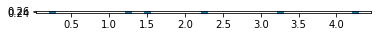

In [179]:
a.plot()

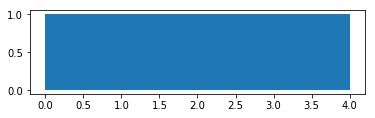

In [180]:
g2 = pd.Series([box(0,0,1,1),box(1,0,2,1),box(2,0,3,1),box(3,0,4,1)])
b = gpd.GeoDataFrame(geometry=g2)
b.plot()

In [181]:
joined = gpd.sjoin(a,b, op="within", how='right')
joined.head()

,index_left,geometry
index_right,,
0,0,"POLYGON ((1 0, 1 1, 0 1, 0 0, 1 0))"
1,2,"POLYGON ((2 0, 2 1, 1 1, 1 0, 2 0))"
1,1,"POLYGON ((2 0, 2 1, 1 1, 1 0, 2 0))"
2,3,"POLYGON ((3 0, 3 1, 2 1, 2 0, 3 0))"
3,4,"POLYGON ((4 0, 4 1, 3 1, 3 0, 4 0))"


In [182]:
joined.dissolve(by=joined.index)

,geometry,index_left
index_right,,
0,"POLYGON ((1 0, 1 1, 0 1, 0 0, 1 0))",0
1,"POLYGON ((2 1, 2 0, 1 0, 1 1, 2 1))",2
2,"POLYGON ((3 0, 3 1, 2 1, 2 0, 3 0))",3
3,"POLYGON ((4 0, 4 1, 3 1, 3 0, 4 0))",4


In [183]:
a = box(0,0,1,1)
b = Point(0,0)
c = Point(.5,.5)
d = Point(.5,0)
a.contains(d)

False

## merge bathymetry data

In [184]:
bathymetry.head()
bathymetry.shape

(5371, 4)

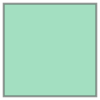

In [185]:
grid_df.iloc[0].geometry

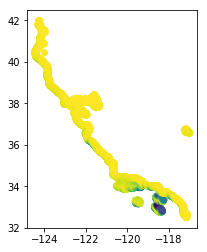

In [186]:
bathymetry.plot(column='z')

In [187]:
def get_value_at_point(shape, pnts, vals, n_closest=5):
    distances = [shape.distance(i) for i in pnts]
    closest_points = np.argsort(distances)[:n_closest]
    return np.mean(vals.iloc[closest_points])

In [188]:
#get_value_at_point(grid_df.geometry, ocean_bathymetry.geometry, ocean_bathymetry.z)
grid_df['depth'] = grid_df.geometry.apply(lambda x: get_value_at_point(x, bathymetry.geometry, bathymetry.z))
grid_df.head()

,geometry,polygon_id,land_distance,pretected_areas,county,critical_species,nes_estab_pct,annual_avg_emplvl,qcew_emp_pct,unemployment_rate,biomass,depth
0,POLYGON ((-124.4718600352303 40.41072536363637...,4576,5.436725,"[(10, South Cape Mendocino State Marine Reserv...","[(21, Humboldt, 5.436724953944683)]","[(41, green sturgeon, 0.0), (22, stellar sea l...","[(21, 0.0016440403180747229, 5.436724953944683)]","[(21, 23.0, 5.436724953944683)]","[(21, 0.000169361125824495, 5.436724953944683)]","[(21, 3.8285714285714287, 5.436724953944683)]",0.0,-38.4
1,POLYGON ((-124.4718600352303 40.42072077272727...,4577,5.210421,"[(10, South Cape Mendocino State Marine Reserv...","[(21, Humboldt, 5.21042108067394)]","[(41, green sturgeon, 0.0), (22, stellar sea l...","[(21, 0.0016440403180747229, 5.21042108067394)]","[(21, 23.0, 5.21042108067394)]","[(21, 0.000169361125824495, 5.21042108067394)]","[(21, 3.8285714285714287, 5.21042108067394)]",0.0,-34.8
2,POLYGON ((-124.4718600352303 40.43071618181818...,4578,5.159305,"[(10, South Cape Mendocino State Marine Reserv...","[(21, Humboldt, 5.159304624869962)]","[(41, green sturgeon, 0.0), (22, stellar sea l...","[(21, 0.0016440403180747229, 5.159304624869962)]","[(21, 23.0, 5.159304624869962)]","[(21, 0.000169361125824495, 5.159304624869962)]","[(21, 3.8285714285714287, 5.159304624869962)]",0.0,-31.0
3,POLYGON ((-124.4718600352303 40.44071159090909...,4579,5.165576,"[(10, South Cape Mendocino State Marine Reserv...","[(21, Humboldt, 5.1655764432122115)]","[(41, green sturgeon, 0.0), (22, stellar sea l...","[(21, 0.0016440403180747229, 5.1655764432122115)]","[(21, 23.0, 5.1655764432122115)]","[(21, 0.000169361125824495, 5.1655764432122115)]","[(21, 3.8285714285714287, 5.1655764432122115)]",0.0,-31.0
4,"POLYGON ((-124.4718600352303 40.450707, -124.4...",4580,5.307229,"[(10, South Cape Mendocino State Marine Reserv...","[(21, Humboldt, 5.30722856721387)]","[(41, green sturgeon, 0.0), (22, stellar sea l...","[(21, 0.0016440403180747229, 5.30722856721387)]","[(21, 23.0, 5.30722856721387)]","[(21, 0.000169361125824495, 5.30722856721387)]","[(21, 3.8285714285714287, 5.30722856721387)]",0.0,-30.4


# merge sst data

In [189]:
sst.head()

,mean_temp,max_temp,min_temp,geometry
0,16.686864,19.299982,14.749994,POINT (-124 32.5)
1,16.615615,19.239984,14.249994,POINT (-123.75 32.5)
2,16.574993,19.200006,13.829980,POINT (-123.5 32.5)
3,16.543119,19.159998,13.589990,POINT (-123.25 32.5)
4,16.536871,19.129999,13.359979,POINT (-123 32.5)


In [190]:
grid_df['mean_sst'] = grid_df.geometry.apply(lambda x: get_value_at_point(x, sst.geometry, sst.mean_temp))
grid_df['max_sst'] = grid_df.geometry.apply(lambda x: get_value_at_point(x, sst.geometry, sst.max_temp))
grid_df['min_sst'] = grid_df.geometry.apply(lambda x: get_value_at_point(x, sst.geometry, sst.min_temp))
#a = get_value_at_point(grid_df.iloc[1].geometry, sst.geometry,sst.mean_temp)
#print(a)
#print(sst.iloc[898])
grid_df.head()

,geometry,polygon_id,land_distance,pretected_areas,county,critical_species,nes_estab_pct,annual_avg_emplvl,qcew_emp_pct,unemployment_rate,biomass,depth,mean_sst,max_sst,min_sst
0,POLYGON ((-124.4718600352303 40.41072536363637...,4576,5.436725,"[(10, South Cape Mendocino State Marine Reserv...","[(21, Humboldt, 5.436724953944683)]","[(41, green sturgeon, 0.0), (22, stellar sea l...","[(21, 0.0016440403180747229, 5.436724953944683)]","[(21, 23.0, 5.436724953944683)]","[(21, 0.000169361125824495, 5.436724953944683)]","[(21, 3.8285714285714287, 5.436724953944683)]",0.0,-38.4,11.929242,14.013989,9.125995
1,POLYGON ((-124.4718600352303 40.42072077272727...,4577,5.210421,"[(10, South Cape Mendocino State Marine Reserv...","[(21, Humboldt, 5.21042108067394)]","[(41, green sturgeon, 0.0), (22, stellar sea l...","[(21, 0.0016440403180747229, 5.21042108067394)]","[(21, 23.0, 5.21042108067394)]","[(21, 0.000169361125824495, 5.21042108067394)]","[(21, 3.8285714285714287, 5.21042108067394)]",0.0,-34.8,11.929242,14.013989,9.125995
2,POLYGON ((-124.4718600352303 40.43071618181818...,4578,5.159305,"[(10, South Cape Mendocino State Marine Reserv...","[(21, Humboldt, 5.159304624869962)]","[(41, green sturgeon, 0.0), (22, stellar sea l...","[(21, 0.0016440403180747229, 5.159304624869962)]","[(21, 23.0, 5.159304624869962)]","[(21, 0.000169361125824495, 5.159304624869962)]","[(21, 3.8285714285714287, 5.159304624869962)]",0.0,-31.0,11.929242,14.013989,9.125995
3,POLYGON ((-124.4718600352303 40.44071159090909...,4579,5.165576,"[(10, South Cape Mendocino State Marine Reserv...","[(21, Humboldt, 5.1655764432122115)]","[(41, green sturgeon, 0.0), (22, stellar sea l...","[(21, 0.0016440403180747229, 5.1655764432122115)]","[(21, 23.0, 5.1655764432122115)]","[(21, 0.000169361125824495, 5.1655764432122115)]","[(21, 3.8285714285714287, 5.1655764432122115)]",0.0,-31.0,11.929242,14.013989,9.125995
4,"POLYGON ((-124.4718600352303 40.450707, -124.4...",4580,5.307229,"[(10, South Cape Mendocino State Marine Reserv...","[(21, Humboldt, 5.30722856721387)]","[(41, green sturgeon, 0.0), (22, stellar sea l...","[(21, 0.0016440403180747229, 5.30722856721387)]","[(21, 23.0, 5.30722856721387)]","[(21, 0.000169361125824495, 5.30722856721387)]","[(21, 3.8285714285714287, 5.30722856721387)]",0.0,-30.4,11.929242,14.013989,9.125995


# merge ndvi

In [191]:
ndvi = pd.read_csv('../spectral/ndvi.csv')
geom = ndvi.apply(lambda x : Point([x['lon'],x['lat']]), axis=1)
ndvi = gpd.GeoDataFrame(ndvi, geometry = geom, crs = {'init' : 'epsg:4326'})
ndvi.drop(['lat','lon'], axis=1, inplace=True)
ndvi.head()

,ndvi,geometry
0,0.008434,POINT (-122.1670025170002 36.99928121643993)
1,-0.020347,POINT (-122.1497959339712 36.98521902016441)
2,0.014294,POINT (-122.1239862600261 36.97115679037713)
3,-0.020140,POINT (-122.115383089949 36.96412566291804)
4,-0.014558,POINT (-122.0981768332691 36.95709452708277)


In [192]:
grid_df['ndvi'] = grid_df.geometry.apply(lambda x: get_value_at_point(x, ndvi.geometry, ndvi.ndvi, n_closest=1))
grid_df.head()

,geometry,polygon_id,land_distance,pretected_areas,county,critical_species,nes_estab_pct,annual_avg_emplvl,qcew_emp_pct,unemployment_rate,biomass,depth,mean_sst,max_sst,min_sst,ndvi
0,POLYGON ((-124.4718600352303 40.41072536363637...,4576,5.436725,"[(10, South Cape Mendocino State Marine Reserv...","[(21, Humboldt, 5.436724953944683)]","[(41, green sturgeon, 0.0), (22, stellar sea l...","[(21, 0.0016440403180747229, 5.436724953944683)]","[(21, 23.0, 5.436724953944683)]","[(21, 0.000169361125824495, 5.436724953944683)]","[(21, 3.8285714285714287, 5.436724953944683)]",0.0,-38.4,11.929242,14.013989,9.125995,0.008434
1,POLYGON ((-124.4718600352303 40.42072077272727...,4577,5.210421,"[(10, South Cape Mendocino State Marine Reserv...","[(21, Humboldt, 5.21042108067394)]","[(41, green sturgeon, 0.0), (22, stellar sea l...","[(21, 0.0016440403180747229, 5.21042108067394)]","[(21, 23.0, 5.21042108067394)]","[(21, 0.000169361125824495, 5.21042108067394)]","[(21, 3.8285714285714287, 5.21042108067394)]",0.0,-34.8,11.929242,14.013989,9.125995,0.008434
2,POLYGON ((-124.4718600352303 40.43071618181818...,4578,5.159305,"[(10, South Cape Mendocino State Marine Reserv...","[(21, Humboldt, 5.159304624869962)]","[(41, green sturgeon, 0.0), (22, stellar sea l...","[(21, 0.0016440403180747229, 5.159304624869962)]","[(21, 23.0, 5.159304624869962)]","[(21, 0.000169361125824495, 5.159304624869962)]","[(21, 3.8285714285714287, 5.159304624869962)]",0.0,-31.0,11.929242,14.013989,9.125995,0.008434
3,POLYGON ((-124.4718600352303 40.44071159090909...,4579,5.165576,"[(10, South Cape Mendocino State Marine Reserv...","[(21, Humboldt, 5.1655764432122115)]","[(41, green sturgeon, 0.0), (22, stellar sea l...","[(21, 0.0016440403180747229, 5.1655764432122115)]","[(21, 23.0, 5.1655764432122115)]","[(21, 0.000169361125824495, 5.1655764432122115)]","[(21, 3.8285714285714287, 5.1655764432122115)]",0.0,-31.0,11.929242,14.013989,9.125995,0.008434
4,"POLYGON ((-124.4718600352303 40.450707, -124.4...",4580,5.307229,"[(10, South Cape Mendocino State Marine Reserv...","[(21, Humboldt, 5.30722856721387)]","[(41, green sturgeon, 0.0), (22, stellar sea l...","[(21, 0.0016440403180747229, 5.30722856721387)]","[(21, 23.0, 5.30722856721387)]","[(21, 0.000169361125824495, 5.30722856721387)]","[(21, 3.8285714285714287, 5.30722856721387)]",0.0,-30.4,11.929242,14.013989,9.125995,0.008434


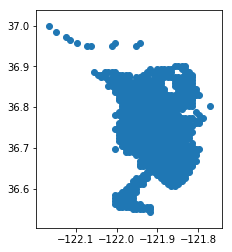

In [193]:
ndvi.plot()

# merge minimum light

In [194]:
grid_df['z_min_light'] = grid_df.geometry.apply(lambda x: get_value_at_point(x, z_min_light.geometry, z_min_light.z_min_light))
grid_df.head()

,geometry,polygon_id,land_distance,pretected_areas,county,critical_species,nes_estab_pct,annual_avg_emplvl,qcew_emp_pct,unemployment_rate,biomass,depth,mean_sst,max_sst,min_sst,ndvi,z_min_light
0,POLYGON ((-124.4718600352303 40.41072536363637...,4576,5.436725,"[(10, South Cape Mendocino State Marine Reserv...","[(21, Humboldt, 5.436724953944683)]","[(41, green sturgeon, 0.0), (22, stellar sea l...","[(21, 0.0016440403180747229, 5.436724953944683)]","[(21, 23.0, 5.436724953944683)]","[(21, 0.000169361125824495, 5.436724953944683)]","[(21, 3.8285714285714287, 5.436724953944683)]",0.0,-38.4,11.929242,14.013989,9.125995,0.008434,34.0
1,POLYGON ((-124.4718600352303 40.42072077272727...,4577,5.210421,"[(10, South Cape Mendocino State Marine Reserv...","[(21, Humboldt, 5.21042108067394)]","[(41, green sturgeon, 0.0), (22, stellar sea l...","[(21, 0.0016440403180747229, 5.21042108067394)]","[(21, 23.0, 5.21042108067394)]","[(21, 0.000169361125824495, 5.21042108067394)]","[(21, 3.8285714285714287, 5.21042108067394)]",0.0,-34.8,11.929242,14.013989,9.125995,0.008434,31.0
2,POLYGON ((-124.4718600352303 40.43071618181818...,4578,5.159305,"[(10, South Cape Mendocino State Marine Reserv...","[(21, Humboldt, 5.159304624869962)]","[(41, green sturgeon, 0.0), (22, stellar sea l...","[(21, 0.0016440403180747229, 5.159304624869962)]","[(21, 23.0, 5.159304624869962)]","[(21, 0.000169361125824495, 5.159304624869962)]","[(21, 3.8285714285714287, 5.159304624869962)]",0.0,-31.0,11.929242,14.013989,9.125995,0.008434,31.0
3,POLYGON ((-124.4718600352303 40.44071159090909...,4579,5.165576,"[(10, South Cape Mendocino State Marine Reserv...","[(21, Humboldt, 5.1655764432122115)]","[(41, green sturgeon, 0.0), (22, stellar sea l...","[(21, 0.0016440403180747229, 5.1655764432122115)]","[(21, 23.0, 5.1655764432122115)]","[(21, 0.000169361125824495, 5.1655764432122115)]","[(21, 3.8285714285714287, 5.1655764432122115)]",0.0,-31.0,11.929242,14.013989,9.125995,0.008434,28.0
4,"POLYGON ((-124.4718600352303 40.450707, -124.4...",4580,5.307229,"[(10, South Cape Mendocino State Marine Reserv...","[(21, Humboldt, 5.30722856721387)]","[(41, green sturgeon, 0.0), (22, stellar sea l...","[(21, 0.0016440403180747229, 5.30722856721387)]","[(21, 23.0, 5.30722856721387)]","[(21, 0.000169361125824495, 5.30722856721387)]","[(21, 3.8285714285714287, 5.30722856721387)]",0.0,-30.4,11.929242,14.013989,9.125995,0.008434,28.0


# merge mixed layer

In [195]:
grid_df['z_mixedl'] = grid_df.geometry.apply(lambda x: get_value_at_point(x, mixedl.geometry, mixedl.mean_mld))
grid_df.head()

,geometry,polygon_id,land_distance,pretected_areas,county,critical_species,nes_estab_pct,annual_avg_emplvl,qcew_emp_pct,unemployment_rate,biomass,depth,mean_sst,max_sst,min_sst,ndvi,z_min_light,z_mixedl
0,POLYGON ((-124.4718600352303 40.41072536363637...,4576,5.436725,"[(10, South Cape Mendocino State Marine Reserv...","[(21, Humboldt, 5.436724953944683)]","[(41, green sturgeon, 0.0), (22, stellar sea l...","[(21, 0.0016440403180747229, 5.436724953944683)]","[(21, 23.0, 5.436724953944683)]","[(21, 0.000169361125824495, 5.436724953944683)]","[(21, 3.8285714285714287, 5.436724953944683)]",0.0,-38.4,11.929242,14.013989,9.125995,0.008434,34.0,17.955626
1,POLYGON ((-124.4718600352303 40.42072077272727...,4577,5.210421,"[(10, South Cape Mendocino State Marine Reserv...","[(21, Humboldt, 5.21042108067394)]","[(41, green sturgeon, 0.0), (22, stellar sea l...","[(21, 0.0016440403180747229, 5.21042108067394)]","[(21, 23.0, 5.21042108067394)]","[(21, 0.000169361125824495, 5.21042108067394)]","[(21, 3.8285714285714287, 5.21042108067394)]",0.0,-34.8,11.929242,14.013989,9.125995,0.008434,31.0,17.955626
2,POLYGON ((-124.4718600352303 40.43071618181818...,4578,5.159305,"[(10, South Cape Mendocino State Marine Reserv...","[(21, Humboldt, 5.159304624869962)]","[(41, green sturgeon, 0.0), (22, stellar sea l...","[(21, 0.0016440403180747229, 5.159304624869962)]","[(21, 23.0, 5.159304624869962)]","[(21, 0.000169361125824495, 5.159304624869962)]","[(21, 3.8285714285714287, 5.159304624869962)]",0.0,-31.0,11.929242,14.013989,9.125995,0.008434,31.0,17.955626
3,POLYGON ((-124.4718600352303 40.44071159090909...,4579,5.165576,"[(10, South Cape Mendocino State Marine Reserv...","[(21, Humboldt, 5.1655764432122115)]","[(41, green sturgeon, 0.0), (22, stellar sea l...","[(21, 0.0016440403180747229, 5.1655764432122115)]","[(21, 23.0, 5.1655764432122115)]","[(21, 0.000169361125824495, 5.1655764432122115)]","[(21, 3.8285714285714287, 5.1655764432122115)]",0.0,-31.0,11.929242,14.013989,9.125995,0.008434,28.0,17.955626
4,"POLYGON ((-124.4718600352303 40.450707, -124.4...",4580,5.307229,"[(10, South Cape Mendocino State Marine Reserv...","[(21, Humboldt, 5.30722856721387)]","[(41, green sturgeon, 0.0), (22, stellar sea l...","[(21, 0.0016440403180747229, 5.30722856721387)]","[(21, 23.0, 5.30722856721387)]","[(21, 0.000169361125824495, 5.30722856721387)]","[(21, 3.8285714285714287, 5.30722856721387)]",0.0,-30.4,11.929242,14.013989,9.125995,0.008434,28.0,17.955626


# merge seafloor temperatures

In [196]:
grid_df['floor_temp'] = grid_df.geometry.apply(lambda x: get_value_at_point(x, floor_temps.geometry, floor_temps.temp_floor))
grid_df.head()

,geometry,polygon_id,land_distance,pretected_areas,county,critical_species,nes_estab_pct,annual_avg_emplvl,qcew_emp_pct,unemployment_rate,biomass,depth,mean_sst,max_sst,min_sst,ndvi,z_min_light,z_mixedl,floor_temp
0,POLYGON ((-124.4718600352303 40.41072536363637...,4576,5.436725,"[(10, South Cape Mendocino State Marine Reserv...","[(21, Humboldt, 5.436724953944683)]","[(41, green sturgeon, 0.0), (22, stellar sea l...","[(21, 0.0016440403180747229, 5.436724953944683)]","[(21, 23.0, 5.436724953944683)]","[(21, 0.000169361125824495, 5.436724953944683)]","[(21, 3.8285714285714287, 5.436724953944683)]",0.0,-38.4,11.929242,14.013989,9.125995,0.008434,34.0,17.955626,8.156
1,POLYGON ((-124.4718600352303 40.42072077272727...,4577,5.210421,"[(10, South Cape Mendocino State Marine Reserv...","[(21, Humboldt, 5.21042108067394)]","[(41, green sturgeon, 0.0), (22, stellar sea l...","[(21, 0.0016440403180747229, 5.21042108067394)]","[(21, 23.0, 5.21042108067394)]","[(21, 0.000169361125824495, 5.21042108067394)]","[(21, 3.8285714285714287, 5.21042108067394)]",0.0,-34.8,11.929242,14.013989,9.125995,0.008434,31.0,17.955626,8.156
2,POLYGON ((-124.4718600352303 40.43071618181818...,4578,5.159305,"[(10, South Cape Mendocino State Marine Reserv...","[(21, Humboldt, 5.159304624869962)]","[(41, green sturgeon, 0.0), (22, stellar sea l...","[(21, 0.0016440403180747229, 5.159304624869962)]","[(21, 23.0, 5.159304624869962)]","[(21, 0.000169361125824495, 5.159304624869962)]","[(21, 3.8285714285714287, 5.159304624869962)]",0.0,-31.0,11.929242,14.013989,9.125995,0.008434,31.0,17.955626,8.156
3,POLYGON ((-124.4718600352303 40.44071159090909...,4579,5.165576,"[(10, South Cape Mendocino State Marine Reserv...","[(21, Humboldt, 5.1655764432122115)]","[(41, green sturgeon, 0.0), (22, stellar sea l...","[(21, 0.0016440403180747229, 5.1655764432122115)]","[(21, 23.0, 5.1655764432122115)]","[(21, 0.000169361125824495, 5.1655764432122115)]","[(21, 3.8285714285714287, 5.1655764432122115)]",0.0,-31.0,11.929242,14.013989,9.125995,0.008434,28.0,17.955626,8.156
4,"POLYGON ((-124.4718600352303 40.450707, -124.4...",4580,5.307229,"[(10, South Cape Mendocino State Marine Reserv...","[(21, Humboldt, 5.30722856721387)]","[(41, green sturgeon, 0.0), (22, stellar sea l...","[(21, 0.0016440403180747229, 5.30722856721387)]","[(21, 23.0, 5.30722856721387)]","[(21, 0.000169361125824495, 5.30722856721387)]","[(21, 3.8285714285714287, 5.30722856721387)]",0.0,-30.4,11.929242,14.013989,9.125995,0.008434,28.0,17.955626,8.156


# use formula to say which sites are good for kelp

In [197]:
#based on http://www.pnas.org/content/104/42/16576
def viable_site(row):
    right_temp = row.floor_temp <= 23
    floor_below_mixedl = -row.depth >= row.z_mixedl
    minimum_light = -row.depth <= row.z_min_light
    #return if all the above conditions are met
    return right_temp and floor_below_mixedl and minimum_light

grid_df['viable'] = grid_df.apply(viable_site, axis=1)
grid_df.head()

,geometry,polygon_id,land_distance,pretected_areas,county,critical_species,nes_estab_pct,annual_avg_emplvl,qcew_emp_pct,unemployment_rate,biomass,depth,mean_sst,max_sst,min_sst,ndvi,z_min_light,z_mixedl,floor_temp,viable
0,POLYGON ((-124.4718600352303 40.41072536363637...,4576,5.436725,"[(10, South Cape Mendocino State Marine Reserv...","[(21, Humboldt, 5.436724953944683)]","[(41, green sturgeon, 0.0), (22, stellar sea l...","[(21, 0.0016440403180747229, 5.436724953944683)]","[(21, 23.0, 5.436724953944683)]","[(21, 0.000169361125824495, 5.436724953944683)]","[(21, 3.8285714285714287, 5.436724953944683)]",0.0,-38.4,11.929242,14.013989,9.125995,0.008434,34.0,17.955626,8.156,False
1,POLYGON ((-124.4718600352303 40.42072077272727...,4577,5.210421,"[(10, South Cape Mendocino State Marine Reserv...","[(21, Humboldt, 5.21042108067394)]","[(41, green sturgeon, 0.0), (22, stellar sea l...","[(21, 0.0016440403180747229, 5.21042108067394)]","[(21, 23.0, 5.21042108067394)]","[(21, 0.000169361125824495, 5.21042108067394)]","[(21, 3.8285714285714287, 5.21042108067394)]",0.0,-34.8,11.929242,14.013989,9.125995,0.008434,31.0,17.955626,8.156,False
2,POLYGON ((-124.4718600352303 40.43071618181818...,4578,5.159305,"[(10, South Cape Mendocino State Marine Reserv...","[(21, Humboldt, 5.159304624869962)]","[(41, green sturgeon, 0.0), (22, stellar sea l...","[(21, 0.0016440403180747229, 5.159304624869962)]","[(21, 23.0, 5.159304624869962)]","[(21, 0.000169361125824495, 5.159304624869962)]","[(21, 3.8285714285714287, 5.159304624869962)]",0.0,-31.0,11.929242,14.013989,9.125995,0.008434,31.0,17.955626,8.156,True
3,POLYGON ((-124.4718600352303 40.44071159090909...,4579,5.165576,"[(10, South Cape Mendocino State Marine Reserv...","[(21, Humboldt, 5.1655764432122115)]","[(41, green sturgeon, 0.0), (22, stellar sea l...","[(21, 0.0016440403180747229, 5.1655764432122115)]","[(21, 23.0, 5.1655764432122115)]","[(21, 0.000169361125824495, 5.1655764432122115)]","[(21, 3.8285714285714287, 5.1655764432122115)]",0.0,-31.0,11.929242,14.013989,9.125995,0.008434,28.0,17.955626,8.156,False
4,"POLYGON ((-124.4718600352303 40.450707, -124.4...",4580,5.307229,"[(10, South Cape Mendocino State Marine Reserv...","[(21, Humboldt, 5.30722856721387)]","[(41, green sturgeon, 0.0), (22, stellar sea l...","[(21, 0.0016440403180747229, 5.30722856721387)]","[(21, 23.0, 5.30722856721387)]","[(21, 0.000169361125824495, 5.30722856721387)]","[(21, 3.8285714285714287, 5.30722856721387)]",0.0,-30.4,11.929242,14.013989,9.125995,0.008434,28.0,17.955626,8.156,False


In [198]:
grid_df[grid_df.viable == True].head()

,geometry,polygon_id,land_distance,pretected_areas,county,critical_species,nes_estab_pct,annual_avg_emplvl,qcew_emp_pct,unemployment_rate,biomass,depth,mean_sst,max_sst,min_sst,ndvi,z_min_light,z_mixedl,floor_temp,viable
2,POLYGON ((-124.4718600352303 40.43071618181818...,4578,5.159305,"[(10, South Cape Mendocino State Marine Reserv...","[(21, Humboldt, 5.159304624869962)]","[(41, green sturgeon, 0.0), (22, stellar sea l...","[(21, 0.0016440403180747229, 5.159304624869962)]","[(21, 23.0, 5.159304624869962)]","[(21, 0.000169361125824495, 5.159304624869962)]","[(21, 3.8285714285714287, 5.159304624869962)]",0.0,-31.0,11.929242,14.013989,9.125995,0.008434,31.0,17.955626,8.156,True
9,POLYGON ((-124.4618627940379 40.43071618181818...,5525,4.172510,"[(10, South Cape Mendocino State Marine Reserv...","[(21, Humboldt, 4.172509814278243)]","[(41, green sturgeon, 0.0), (22, stellar sea l...","[(21, 0.0016440403180747229, 4.172509814278243)]","[(21, 23.0, 4.172509814278243)]","[(21, 0.000169361125824495, 4.172509814278243)]","[(21, 3.8285714285714287, 4.172509814278243)]",0.0,-29.8,11.929242,14.013989,9.125995,0.008434,31.0,17.955626,8.156,True
20,POLYGON ((-124.4518655528455 40.43071618181818...,6472,3.185715,"[(10, South Cape Mendocino State Marine Reserv...","[(21, Humboldt, 3.185715003686525)]","[(41, green sturgeon, 0.0), (22, stellar sea l...","[(21, 0.0016440403180747229, 3.185715003686525)]","[(21, 23.0, 3.185715003686525)]","[(21, 0.000169361125824495, 3.185715003686525)]","[(21, 3.8285714285714287, 3.185715003686525)]",0.0,-29.8,11.929242,14.013989,9.125995,0.008434,31.0,17.955626,8.156,True
53,POLYGON ((-124.4318710704607 40.42072077272727...,8365,1.412996,"[(10, South Cape Mendocino State Marine Reserv...","[(21, Humboldt, 1.4129959372223702)]","[(41, green sturgeon, 0.0), (22, stellar sea l...","[(21, 0.0016440403180747229, 1.4129959372223702)]","[(21, 23.0, 1.4129959372223702)]","[(21, 0.000169361125824495, 1.4129959372223702)]","[(21, 3.8285714285714287, 1.4129959372223702)]",0.0,-25.0,11.929242,14.013989,9.125995,0.008434,25.0,17.955626,8.156,True
54,POLYGON ((-124.4318710704607 40.43071618181818...,8366,1.212125,"[(10, South Cape Mendocino State Marine Reserv...","[(21, Humboldt, 1.2121253825016851)]","[(41, green sturgeon, 0.0), (22, stellar sea l...","[(21, 0.0016440403180747229, 1.2121253825016851)]","[(21, 23.0, 1.2121253825016851)]","[(21, 0.000169361125824495, 1.2121253825016851)]","[(21, 3.8285714285714287, 1.2121253825016851)]",0.0,-20.8,11.929242,14.013989,9.125995,0.008434,24.0,17.955626,8.156,True


In [199]:
print(grid_df.z_min_light.mean())
print(grid_df.z_mixedl.mean())
print(grid_df.depth.mean())
print(grid_df.floor_temp.mean())
print(grid_df.shape)
print(grid_df[grid_df.viable == True].shape)

22.743841336116912
18.960240063875446
-68.50089770355497
9.520150991650162
(19160, 20)
(1334, 20)


(array([1.050e+02, 0.000e+00, 0.000e+00, 0.000e+00, 6.000e+00, 2.291e+03,
        1.100e+01, 4.000e+00, 5.300e+01, 4.000e+00, 1.310e+02, 1.600e+01,
        2.320e+02, 2.600e+01, 2.500e+01, 1.090e+02, 2.000e+00, 7.400e+01,
        1.740e+02, 3.540e+02, 1.320e+02, 1.348e+03, 1.098e+03, 5.320e+02,
        7.830e+02, 9.510e+02, 1.338e+03, 1.183e+03, 2.282e+03, 2.136e+03,
        1.148e+03, 6.480e+02, 6.610e+02, 2.600e+02, 2.980e+02, 3.100e+02,
        1.660e+02, 1.790e+02, 1.000e+01, 1.000e+01, 4.700e+01, 4.000e+00,
        5.000e+00, 0.000e+00, 7.000e+00, 3.000e+00, 0.000e+00, 2.000e+00,
        1.000e+00, 1.000e+00]),
 array([ 1.504   ,  1.836828,  2.169656,  2.502484,  2.835312,  3.16814 ,
         3.500968,  3.833796,  4.166624,  4.499452,  4.83228 ,  5.165108,
         5.497936,  5.830764,  6.163592,  6.49642 ,  6.829248,  7.162076,
         7.494904,  7.827732,  8.16056 ,  8.493388,  8.826216,  9.159044,
         9.491872,  9.8247  , 10.157528, 10.490356, 10.823184, 11.156012,
      

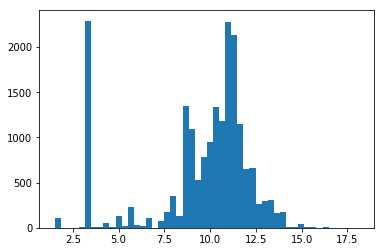

In [200]:
plt.hist(grid_df.floor_temp, bins=50)

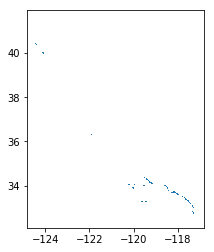

In [201]:
grid_df[grid_df.viable == True].plot()

# merge boat launch sites

In [202]:
boatlaunches = pd.read_pickle(pickles+'boatlaunches.pkl')
grid_df['boat_launches'] = grid_df.geometry.apply(lambda x: get_closest_areas(x,boatlaunches.geometry,\
                                                                                boatlaunches.Type,\
                                                                                10,1))

# merge halibut trawl areas

In [203]:
halibuttrawl = pd.read_pickle(pickles+'halibuttrawl.pkl')
grid_df['halibut_trawl_sites'] = grid_df.geometry.apply(lambda x: get_closest_areas(x,halibuttrawl.geometry,\
                                                                                halibuttrawl.Status,\
                                                                                10,0))

# merge marina data

In [204]:
marinas = pd.read_pickle(pickles+'marinas.pkl')
grid_df['marinas'] = grid_df.geometry.apply(lambda x: get_closest_areas(x,marinas.geometry,\
                                                                                marinas.Name,\
                                                                                10,0))

# merge oil platform data

In [205]:
oilplats = pd.read_pickle(pickles+'oilplats.pkl')
grid_df['oil_platforms'] = grid_df.geometry.apply(lambda x: get_closest_areas(x,oilplats.geometry,\
                                                                                oilplats.NAME,\
                                                                                10,0))

# merge piers data

In [206]:
piers = pd.read_pickle(pickles+'piers.pkl')
grid_df['piers'] = grid_df.geometry.apply(lambda x: get_closest_areas(x,piers.geometry,\
                                                                        piers.PNT_NAME,\
                                                                        1,0))
grid_df[grid_df.piers.apply(len)>0].head()

,geometry,polygon_id,land_distance,pretected_areas,county,critical_species,nes_estab_pct,annual_avg_emplvl,qcew_emp_pct,unemployment_rate,...,ndvi,z_min_light,z_mixedl,floor_temp,viable,boat_launches,halibut_trawl_sites,marinas,oil_platforms,piers
635,POLYGON ((-124.2519207289973 40.74057386363636...,25443,0.000000,"[(8, South Humboldt Bay State Marine Recreatio...","[(21, Humboldt, 0.0)]","[(41, green sturgeon, 0.0), (33, green sturgeo...","[(21, 0.0016440403180747229, 0.0)]","[(21, 23.0, 0.0)]","[(21, 0.000169361125824495, 0.0)]","[(21, 3.8285714285714287, 0.0)]",...,0.008434,5.0,17.955626,8.752,False,"[(118, Launch Ramp, 2.4156456646442335), (51, ...",[],"[(192, Johnny's Marina, 2.339545350184295), (1...",[],"[(146, South Jetty Humboldt Bay, 0.95260796385..."
636,POLYGON ((-124.2519207289973 40.75056927272728...,25444,0.176754,"[(8, South Humboldt Bay State Marine Recreatio...","[(21, Humboldt, 0.17675446190472935)]","[(41, green sturgeon, 0.0), (33, green sturgeo...","[(21, 0.0016440403180747229, 0.176754461904729...","[(21, 23.0, 0.17675446190472935)]","[(21, 0.000169361125824495, 0.17675446190472935)]","[(21, 3.8285714285714287, 0.17675446190472935)]",...,0.008434,5.0,17.955626,8.752,False,"[(118, Launch Ramp, 2.7223969010899354), (52, ...",[],"[(192, Johnny's Marina, 2.6179481500980777), (...",[],"[(146, South Jetty Humboldt Bay, 0.61572644672..."
637,POLYGON ((-124.2519207289973 40.76056468181818...,25445,0.729120,"[(8, South Humboldt Bay State Marine Recreatio...","[(21, Humboldt, 0.7291195040536108)]","[(42, green sturgeon, 0.0), (41, green sturgeo...","[(21, 0.0016440403180747229, 0.7291195040536108)]","[(21, 23.0, 0.7291195040536108)]","[(21, 0.000169361125824495, 0.7291195040536108)]","[(21, 3.8285714285714287, 0.7291195040536108)]",...,0.008434,5.0,17.955626,8.752,False,"[(52, Launch Ramp, 2.8993270517486156), (118, ...",[],"[(192, Johnny's Marina, 3.1895612988700264), (...",[],"[(146, South Jetty Humboldt Bay, 0.66741405030..."
638,POLYGON ((-124.2519207289973 40.77056009090909...,25446,1.281424,"[(8, South Humboldt Bay State Marine Recreatio...","[(21, Humboldt, 1.2814237290361863)]","[(42, green sturgeon, 0.0), (33, green sturgeo...","[(21, 0.0016440403180747229, 1.2814237290361863)]","[(21, 23.0, 1.2814237290361863)]","[(21, 0.000169361125824495, 1.2814237290361863)]","[(21, 3.8285714285714287, 1.2814237290361863)]",...,0.008434,10.0,17.955626,8.752,False,"[(52, Launch Ramp, 2.895526802242368), (118, L...",[],"[(193, The Local Fish Company (former King Sal...",[],"[(145, North Jetty Humboldt Bay, 0.99006194194..."
685,POLYGON ((-124.2419234878049 40.74057386363636...,26390,0.000000,"[(8, South Humboldt Bay State Marine Recreatio...","[(21, Humboldt, 0.0)]","[(41, green sturgeon, 0.0), (33, green sturgeo...","[(21, 0.0016440403180747229, 0.0)]","[(21, 23.0, 0.0)]","[(21, 0.000169361125824495, 0.0)]","[(21, 3.8285714285714287, 0.0)]",...,0.008434,5.0,17.955626,8.752,False,"[(118, Launch Ramp, 1.4440461302788405), (51, ...",[],"[(192, Johnny's Marina, 1.3611862110814257), (...",[],"[(146, South Jetty Humboldt Bay, 0.72684327377..."


# merge shoretypes data

In [207]:
shoretype = pd.read_pickle(pickles+'shoretypes.pkl')
grid_df['shoretype'] = grid_df.geometry.apply(lambda x: get_closest_areas(x,shoretype.geometry,\
                                                                        shoretype.mapclass,\
                                                                        1,1,1))

In [208]:
t0 = time()
grid_df['shoretype2'] = grid_df.geometry.apply(lambda x: get_closest_areas(x,shoretype.geometry,\
                                                                        shoretype.s1name,\
                                                                        1,1,1))
print(time() - t0)
grid_df.head()

6159.047338247299


,geometry,polygon_id,land_distance,pretected_areas,county,critical_species,nes_estab_pct,annual_avg_emplvl,qcew_emp_pct,unemployment_rate,...,z_mixedl,floor_temp,viable,boat_launches,halibut_trawl_sites,marinas,oil_platforms,piers,shoretype,shoretype2
0,POLYGON ((-124.4718600352303 40.41072536363637...,4576,5.436725,"[(10, South Cape Mendocino State Marine Reserv...","[(21, Humboldt, 5.436724953944683)]","[(41, green sturgeon, 0.0), (22, stellar sea l...","[(21, 0.0016440403180747229, 5.436724953944683)]","[(21, 23.0, 5.436724953944683)]","[(21, 0.000169361125824495, 5.436724953944683)]","[(21, 3.8285714285714287, 5.436724953944683)]",...,17.955626,8.156,False,"[(49, Launch Ramp, 27.76327851326807)]",[],[],[],[],"[(2658, Rocky Shores, 4.929982395691511)]","[(2658, exposed rocky cliffs, 4.929982395691511)]"
1,POLYGON ((-124.4718600352303 40.42072077272727...,4577,5.210421,"[(10, South Cape Mendocino State Marine Reserv...","[(21, Humboldt, 5.21042108067394)]","[(41, green sturgeon, 0.0), (22, stellar sea l...","[(21, 0.0016440403180747229, 5.21042108067394)]","[(21, 23.0, 5.21042108067394)]","[(21, 0.000169361125824495, 5.21042108067394)]","[(21, 3.8285714285714287, 5.21042108067394)]",...,17.955626,8.156,False,"[(49, Launch Ramp, 27.00860184597509)]",[],[],[],[],"[(2658, Rocky Shores, 4.672488309467653)]","[(2658, exposed rocky cliffs, 4.672488309467653)]"
2,POLYGON ((-124.4718600352303 40.43071618181818...,4578,5.159305,"[(10, South Cape Mendocino State Marine Reserv...","[(21, Humboldt, 5.159304624869962)]","[(41, green sturgeon, 0.0), (22, stellar sea l...","[(21, 0.0016440403180747229, 5.159304624869962)]","[(21, 23.0, 5.159304624869962)]","[(21, 0.000169361125824495, 5.159304624869962)]","[(21, 3.8285714285714287, 5.159304624869962)]",...,17.955626,8.156,True,"[(49, Launch Ramp, 26.269475764291638)]",[],[],[],[],"[(2658, Rocky Shores, 4.6102871609454885)]","[(2658, exposed rocky cliffs, 4.61028716094548..."
3,POLYGON ((-124.4718600352303 40.44071159090909...,4579,5.165576,"[(10, South Cape Mendocino State Marine Reserv...","[(21, Humboldt, 5.1655764432122115)]","[(41, green sturgeon, 0.0), (22, stellar sea l...","[(21, 0.0016440403180747229, 5.1655764432122115)]","[(21, 23.0, 5.1655764432122115)]","[(21, 0.000169361125824495, 5.1655764432122115)]","[(21, 3.8285714285714287, 5.1655764432122115)]",...,17.955626,8.156,False,"[(49, Launch Ramp, 25.547237515817717)]",[],[],[],[],"[(2658, Rocky Shores, 4.6153170723266905)]","[(2658, exposed rocky cliffs, 4.61531707232669..."
4,"POLYGON ((-124.4718600352303 40.450707, -124.4...",4580,5.307229,"[(10, South Cape Mendocino State Marine Reserv...","[(21, Humboldt, 5.30722856721387)]","[(41, green sturgeon, 0.0), (22, stellar sea l...","[(21, 0.0016440403180747229, 5.30722856721387)]","[(21, 23.0, 5.30722856721387)]","[(21, 0.000169361125824495, 5.30722856721387)]","[(21, 3.8285714285714287, 5.30722856721387)]",...,17.955626,8.156,False,"[(49, Launch Ramp, 24.843347157672767)]",[],[],[],[],"[(2658, Rocky Shores, 4.765236499920285)]","[(2658, exposed rocky cliffs, 4.765236499920285)]"


# merge aerial kelp data

In [209]:
t0 = time()
aerial_kelp = pd.read_pickle(pickles+'aerial_kelp_hundreththkm.pkl')
grid_df['aerial_kelp'] = grid_df.geometry.apply(lambda x: get_closest_areas(x,aerial_kelp.geometry,\
                                                                        aerial_kelp.hasKelp,\
                                                                        1,1,1))
print(time() - t0)
grid_df.head()

3735.6333894729614


,geometry,polygon_id,land_distance,pretected_areas,county,critical_species,nes_estab_pct,annual_avg_emplvl,qcew_emp_pct,unemployment_rate,...,floor_temp,viable,boat_launches,halibut_trawl_sites,marinas,oil_platforms,piers,shoretype,shoretype2,aerial_kelp
0,POLYGON ((-124.4718600352303 40.41072536363637...,4576,5.436725,"[(10, South Cape Mendocino State Marine Reserv...","[(21, Humboldt, 5.436724953944683)]","[(41, green sturgeon, 0.0), (22, stellar sea l...","[(21, 0.0016440403180747229, 5.436724953944683)]","[(21, 23.0, 5.436724953944683)]","[(21, 0.000169361125824495, 5.436724953944683)]","[(21, 3.8285714285714287, 5.436724953944683)]",...,8.156,False,"[(49, Launch Ramp, 27.76327851326807)]",[],[],[],[],"[(2658, Rocky Shores, 4.929982395691511)]","[(2658, exposed rocky cliffs, 4.929982395691511)]","[(0, False, 0.0)]"
1,POLYGON ((-124.4718600352303 40.42072077272727...,4577,5.210421,"[(10, South Cape Mendocino State Marine Reserv...","[(21, Humboldt, 5.21042108067394)]","[(41, green sturgeon, 0.0), (22, stellar sea l...","[(21, 0.0016440403180747229, 5.21042108067394)]","[(21, 23.0, 5.21042108067394)]","[(21, 0.000169361125824495, 5.21042108067394)]","[(21, 3.8285714285714287, 5.21042108067394)]",...,8.156,False,"[(49, Launch Ramp, 27.00860184597509)]",[],[],[],[],"[(2658, Rocky Shores, 4.672488309467653)]","[(2658, exposed rocky cliffs, 4.672488309467653)]","[(0, False, 0.0)]"
2,POLYGON ((-124.4718600352303 40.43071618181818...,4578,5.159305,"[(10, South Cape Mendocino State Marine Reserv...","[(21, Humboldt, 5.159304624869962)]","[(41, green sturgeon, 0.0), (22, stellar sea l...","[(21, 0.0016440403180747229, 5.159304624869962)]","[(21, 23.0, 5.159304624869962)]","[(21, 0.000169361125824495, 5.159304624869962)]","[(21, 3.8285714285714287, 5.159304624869962)]",...,8.156,True,"[(49, Launch Ramp, 26.269475764291638)]",[],[],[],[],"[(2658, Rocky Shores, 4.6102871609454885)]","[(2658, exposed rocky cliffs, 4.61028716094548...","[(1, False, 0.0)]"
3,POLYGON ((-124.4718600352303 40.44071159090909...,4579,5.165576,"[(10, South Cape Mendocino State Marine Reserv...","[(21, Humboldt, 5.1655764432122115)]","[(41, green sturgeon, 0.0), (22, stellar sea l...","[(21, 0.0016440403180747229, 5.1655764432122115)]","[(21, 23.0, 5.1655764432122115)]","[(21, 0.000169361125824495, 5.1655764432122115)]","[(21, 3.8285714285714287, 5.1655764432122115)]",...,8.156,False,"[(49, Launch Ramp, 25.547237515817717)]",[],[],[],[],"[(2658, Rocky Shores, 4.6153170723266905)]","[(2658, exposed rocky cliffs, 4.61531707232669...","[(2, False, 0.0)]"
4,"POLYGON ((-124.4718600352303 40.450707, -124.4...",4580,5.307229,"[(10, South Cape Mendocino State Marine Reserv...","[(21, Humboldt, 5.30722856721387)]","[(41, green sturgeon, 0.0), (22, stellar sea l...","[(21, 0.0016440403180747229, 5.30722856721387)]","[(21, 23.0, 5.30722856721387)]","[(21, 0.000169361125824495, 5.30722856721387)]","[(21, 3.8285714285714287, 5.30722856721387)]",...,8.156,False,"[(49, Launch Ramp, 24.843347157672767)]",[],[],[],[],"[(2658, Rocky Shores, 4.765236499920285)]","[(2658, exposed rocky cliffs, 4.765236499920285)]","[(11, False, 0.0)]"


In [210]:
grid_df.to_pickle('../data/pickles/grid_df_hundredth.pkl')

# add data post-pickle

In [8]:
grid_df = pd.read_pickle(pickles+'grid_df.pkl')
grid_df.head()

,geometry,polygon_id,land_distance,pretected_areas,county,critical_species,nes_estab_pct,annual_avg_emplvl,qcew_emp_pct,unemployment_rate,...,floor_temp,viable,boat_launches,halibut_trawl_sites,marinas,oil_platforms,piers,shoretype,shoretype2,aerial_kelp
0,"POLYGON ((-124.511849 40.2062109680851, -124.4...",77,4.785556,"[(13, Sea Lion Gulch State Marine Reserve, 0.0...","[(21, Humboldt, 4.785556275622082)]","[(41, green sturgeon, 0.0), (22, stellar sea l...","[(21, 0.0016440403180747229, 4.785556275622082)]","[(21, 23.0, 4.785556275622082)]","[(21, 0.000169361125824495, 4.785556275622082)]","[(21, 3.8285714285714287, 4.785556275622082)]",...,8.584,False,"[(49, Launch Ramp, 35.1320479402703)]",[],[],[],[],"[(5449, Rocky Shores, 4.629738130296758)]","[(5449, exposed wave cut platforms in bedrock,...","[(67, False, 0.0)]"
1,"POLYGON ((-124.511849 40.30584561702128, -124....",78,2.007310,"[(12, Mattole Canyon State Marine Reserve, 0.0...","[(21, Humboldt, 2.00731033547805)]","[(41, green sturgeon, 0.0), (22, stellar sea l...","[(21, 0.0016440403180747229, 2.00731033547805)]","[(21, 23.0, 2.00731033547805)]","[(21, 0.000169361125824495, 2.00731033547805)]","[(21, 3.8285714285714287, 2.00731033547805)]",...,8.156,True,"[(49, Launch Ramp, 26.19130165951806)]",[],[],[],[],"[(5407, Rocky Shores, 1.7033331712822057)]","[(5407, gravel beaches, 1.7033331712822057)]","[(51, False, 0.0)]"
2,"POLYGON ((-124.511849 40.40548026595744, -124....",79,0.222856,"[(9, Sugarloaf Island Special Closure, 0.0), (...","[(21, Humboldt, 0.22285562284475044)]","[(41, green sturgeon, 0.0), (28, stellar sea l...","[(21, 0.0016440403180747229, 0.222855622844750...","[(21, 23.0, 0.22285562284475044)]","[(21, 0.000169361125824495, 0.22285562284475044)]","[(21, 3.8285714285714287, 0.22285562284475044)]",...,8.156,False,"[(49, Launch Ramp, 18.229016964046185)]",[],[],[],[],"[(2658, Rocky Shores, 0.0)]","[(2658, exposed rocky cliffs, 0.0)]","[(0, False, 0.0)]"
3,"POLYGON ((-124.511849 40.50511491489362, -124....",80,2.325414,"[(9, Sugarloaf Island Special Closure, 6.54469...","[(21, Humboldt, 2.32541354349618)]","[(41, green sturgeon, 0.0), (22, stellar sea l...","[(21, 0.0016440403180747229, 2.32541354349618)]","[(21, 23.0, 2.32541354349618)]","[(21, 0.000169361125824495, 2.32541354349618)]","[(21, 3.8285714285714287, 2.32541354349618)]",...,8.156,False,"[(49, Launch Ramp, 13.13645178043086)]",[],[],[],[],"[(5396, Rocky Shores, 1.4899230753799018)]","[(5396, exposed rocky cliffs, 1.48992307537990...","[(95, False, 0.0)]"
4,POLYGON ((-124.4120138767123 40.10657631914894...,171,1.252525,"[(14, Big Flat State Marine Conservation Area,...","[(21, Humboldt, 1.2525254119315425)]","[(41, green sturgeon, 0.0), (22, stellar sea l...","[(21, 0.0016440403180747229, 1.2525254119315425)]","[(21, 23.0, 1.2525254119315425)]","[(21, 0.000169361125824495, 1.2525254119315425)]","[(21, 3.8285714285714287, 1.2525254119315425)]",...,8.910,False,"[(48, Beach Launch, 25.629206056804193)]",[],[],[],[],"[(5463, Rocky Shores, 1.0828265287181142)]","[(5463, gravel beaches, 1.0828265287181142)]","[(386, False, 0.0)]"


## add kelp bed data

In [15]:
kelp_beds = pd.read_pickle(pickles+'kelp_beds.pkl')
kelp_beds.head()

,KelpBed,Exclusions,Status,Shape_Leng,Lessee,TermEnds,Shape_Le_1,Shape_Area,geometry
0,1,None,OPEN,47791.266131,None,None,47791.266131,4.429537e+07,POLYGON ((-117.1298214744443 32.55744564670819...
1,2,None,OPEN,162157.655298,None,None,162157.655298,1.413336e+08,"POLYGON ((-117.206752810309 32.73842071039661,..."
2,3,None,LEASED,35916.074628,"KNOCEAN Sciences, Inc.",2017-04-11,35916.074628,6.300310e+07,POLYGON ((-117.3194690456489 32.75819950486779...
3,4,None,LEASABLE,101285.862462,None,None,101285.862462,9.546491e+07,"POLYGON ((-117.263658785037 32.84930114949404,..."
4,5,None,LEASABLE,41830.085472,None,None,41830.085472,6.637086e+07,POLYGON ((-117.3331999997121 32.97469999957139...


In [16]:
grid_df['admin_kelp_bed'] = grid_df.geometry.apply(lambda x: get_closest_areas(x,kelp_beds.geometry,\
                                                                        kelp_beds.Status,\
                                                                        1,1,1))
grid_df['admin_kelp_bed'] = grid_df.admin_kelp_bed.apply(lambda x: x[0][1])
grid_df.head()

,geometry,polygon_id,land_distance,pretected_areas,county,critical_species,nes_estab_pct,annual_avg_emplvl,qcew_emp_pct,unemployment_rate,...,viable,boat_launches,halibut_trawl_sites,marinas,oil_platforms,piers,shoretype,shoretype2,aerial_kelp,admin_kelp_bed
0,"POLYGON ((-124.511849 40.2062109680851, -124.4...",77,4.785556,"[(13, Sea Lion Gulch State Marine Reserve, 0.0...","[(21, Humboldt, 4.785556275622082)]","[(41, green sturgeon, 0.0), (22, stellar sea l...","[(21, 0.0016440403180747229, 4.785556275622082)]","[(21, 23.0, 4.785556275622082)]","[(21, 0.000169361125824495, 4.785556275622082)]","[(21, 3.8285714285714287, 4.785556275622082)]",...,False,"[(49, Launch Ramp, 35.1320479402703)]",[],[],[],[],"[(5449, Rocky Shores, 4.629738130296758)]","[(5449, exposed wave cut platforms in bedrock,...","[(67, False, 0.0)]","[(83, LEASE ONLY, 0.0)]"
1,"POLYGON ((-124.511849 40.30584561702128, -124....",78,2.007310,"[(12, Mattole Canyon State Marine Reserve, 0.0...","[(21, Humboldt, 2.00731033547805)]","[(41, green sturgeon, 0.0), (22, stellar sea l...","[(21, 0.0016440403180747229, 2.00731033547805)]","[(21, 23.0, 2.00731033547805)]","[(21, 0.000169361125824495, 2.00731033547805)]","[(21, 3.8285714285714287, 2.00731033547805)]",...,True,"[(49, Launch Ramp, 26.19130165951806)]",[],[],[],[],"[(5407, Rocky Shores, 1.7033331712822057)]","[(5407, gravel beaches, 1.7033331712822057)]","[(51, False, 0.0)]","[(83, LEASE ONLY, 0.0)]"
2,"POLYGON ((-124.511849 40.40548026595744, -124....",79,0.222856,"[(9, Sugarloaf Island Special Closure, 0.0), (...","[(21, Humboldt, 0.22285562284475044)]","[(41, green sturgeon, 0.0), (28, stellar sea l...","[(21, 0.0016440403180747229, 0.222855622844750...","[(21, 23.0, 0.22285562284475044)]","[(21, 0.000169361125824495, 0.22285562284475044)]","[(21, 3.8285714285714287, 0.22285562284475044)]",...,False,"[(49, Launch Ramp, 18.229016964046185)]",[],[],[],[],"[(2658, Rocky Shores, 0.0)]","[(2658, exposed rocky cliffs, 0.0)]","[(0, False, 0.0)]","[(84, CLOSED, 0.0)]"
3,"POLYGON ((-124.511849 40.50511491489362, -124....",80,2.325414,"[(9, Sugarloaf Island Special Closure, 6.54469...","[(21, Humboldt, 2.32541354349618)]","[(41, green sturgeon, 0.0), (22, stellar sea l...","[(21, 0.0016440403180747229, 2.32541354349618)]","[(21, 23.0, 2.32541354349618)]","[(21, 0.000169361125824495, 2.32541354349618)]","[(21, 3.8285714285714287, 2.32541354349618)]",...,False,"[(49, Launch Ramp, 13.13645178043086)]",[],[],[],[],"[(5396, Rocky Shores, 1.4899230753799018)]","[(5396, exposed rocky cliffs, 1.48992307537990...","[(95, False, 0.0)]","[(84, CLOSED, 0.0)]"
4,POLYGON ((-124.4120138767123 40.10657631914894...,171,1.252525,"[(14, Big Flat State Marine Conservation Area,...","[(21, Humboldt, 1.2525254119315425)]","[(41, green sturgeon, 0.0), (22, stellar sea l...","[(21, 0.0016440403180747229, 1.2525254119315425)]","[(21, 23.0, 1.2525254119315425)]","[(21, 0.000169361125824495, 1.2525254119315425)]","[(21, 3.8285714285714287, 1.2525254119315425)]",...,False,"[(48, Beach Launch, 25.629206056804193)]",[],[],[],[],"[(5463, Rocky Shores, 1.0828265287181142)]","[(5463, gravel beaches, 1.0828265287181142)]","[(386, False, 0.0)]","[(83, LEASE ONLY, 0.0)]"


In [19]:
grid_df.to_pickle(pickles+'grid_df.pkl')